### Implementa una red completamente conectada para la tarea de clasificacion de imagenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguientes especificaciones

* Explora con diferentes numero de neuronas, capas, funciones de activacion e hiperparametros
* Discutir los resultados con las distintas configuraciones

In [1]:
#Importamos librerias utiles
#deep learning
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizer
import torchvision.datasets.utils as tutils
import torchvision.datasets as DataSets
from torchvision import transforms
#matrices y matematicas
import numpy as np
# tomar n elementos de una secuencia
from itertools import islice as take
#imagenes
from matplotlib import pyplot as plt

In [2]:
#para usar la GPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"

device = torch.device(dev)
print(device)

cuda:0


In [3]:
#cargamos el dataset de fashion-MNIST de train
fmnist_train = DataSets.FashionMNIST(root='\FashionMNIST',train=True, download=True, transform = np.array)
##cargamos el dataset de fashion-MNIST de test
fmnist_test = DataSets.FashionMNIST(root='\FashionMNIST',train=False, download=True, transform = np.array)

In [4]:
#para verificar imprimimos la info de ambos datasets
print(fmnist_train)
print('#'*50)
print(fmnist_test)
# Sembramos semillas para reproducibilidad
np.random.seed(2020)
torch.manual_seed(2020)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: \FashionMNIST
    Split: Train
    StandardTransform
Transform: <built-in function array>
##################################################
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: \FashionMNIST
    Split: Test
    StandardTransform
Transform: <built-in function array>


In [5]:
#creamos una funcion para ver n imagenes con i columnas y j filas
def muestraImagenes(columnas,filas,fmnist):
    #crea dos listas vacias que contendran las imagenes y las etiquetas respectivamente
    images, labels = [], []
    #itera sobre el producto de las filas con las columnas es decir el total de imagenes
    for image in range(int(columnas*filas)):
        #si el argumento es train
        if fmnist == 'train':
            #toma las imagenes y etiquetas del dataset train
            im , lab = fmnist_train[image]
        #si el argumento no es train
        else:
            #toma las imagenes y etiquetas del dataset test
            im , lab = fmnist_test[image]
        #has append a la lista de imagenes con la imagen actual
        images.append(im)
        #has append a la lista de etiquetas con la etiqueta actual
        labels.append(str(lab))
        #convierte a string las etiquetas
        titles = [str(y) for y in labels]
    #define una variable dummy que sirve para iterar sobre todas las imagenes
    contador = 0
    #define el array de imagenes con tamaño de 10x10
    f, axarr = plt.subplots(filas,columnas, figsize=(10,10))
    #itera sobre las filas del array de imagenes
    for fila in range(filas):
        #itera sobre las columnas del array de imagenes
        for columna in range(columnas):
            #muestra la imagen en la posicion de la variable dummy
            axarr[fila,columna].imshow(images[contador],cmap='gray')
            #muestra sobre esa imagen un titulo que corresponde a su etiqueta
            axarr[fila,columna].set_title('Label: {0}'.format(titles[contador]))
            #quita los numeros de los ejes
            axarr[fila,columna].set_xticklabels([])
            axarr[fila,columna].set_yticklabels([])
            #suma uno a la variable dummy
            contador += 1
    #muestra el array de imagenes
    plt.show()

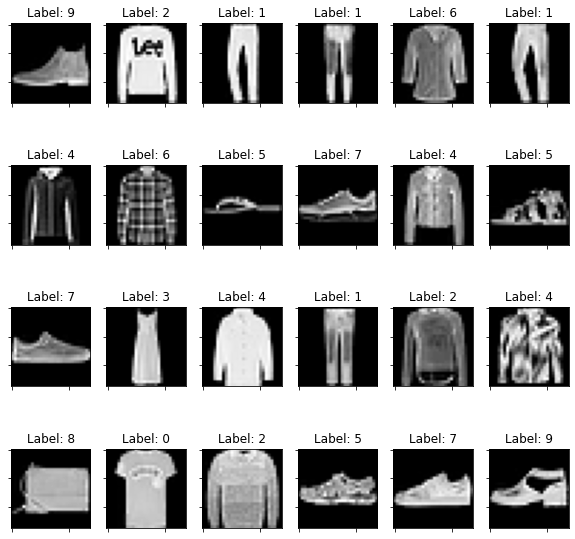

In [6]:
muestraImagenes(columnas=6,filas=4,fmnist='test')

### Preprcesamiento de los datos

In [7]:
#volvemos a cargar ambos datasets pero ahora como tensores de torch
#cargamos el dataset de fashion-MNIST de train
fmnist_train = DataSets.FashionMNIST(root='\FashionMNIST',train=True, download=True, transform = transforms.Compose([
    transforms.ToTensor()]))
##cargamos el dataset de fashion-MNIST de test
fmnist_test = DataSets.FashionMNIST(root='\FashionMNIST',train=False, download=True, transform = transforms.Compose([
    transforms.ToTensor()]))

#ahora vamos a calcular la media y desciacion estandar de cada data set
#esto para normalizar las imagenes ya que las redes neuronales "funcionan" mejor
#con pixeles con valores entre 0 y 1
#Esto se va a hacer de la forma facil, esta forma facil solo es posible para datasets que pueden cargarse
#en memoria de acuerdo a https://deeplizard.com/learn/video/lu7TCu7HeYc

#instanciamos un DataLoader para el dataset de train
loader_train = DataLoader(fmnist_train, batch_size=len(fmnist_train), num_workers=1)
#ponemos en memoria cada imagen usando el iterador y el next de torch
data_train = next(iter(loader_train))
#calculamos la media y la desviacion estandar
mean_train, std_train = data_train[0].mean(), data_train[0].std()
#imprimimos valores
print('La media del dataset de train es {0} y la desviacion estandar es {1}'.format(mean_train, std_train))

La media del dataset de train es 0.2860347330570221 y la desviacion estandar es 0.3530242443084717


In [8]:
#instanciamos un DataLoader para el dataset de train
loader_test = DataLoader(fmnist_test, batch_size=len(fmnist_test), num_workers=1)
#ponemos en memoria cada imagen usando el iterador y el next de torch
data_test = next(iter(loader_test))
#calculamos la media y la desviacion estandar
mean_test, std_test = data_test[0].mean(), data_test[0].std()
#imprimimos valores
print('La media del dataset de test es {0} y la desviacion estandar es {1}'.format(mean_test, std_test))

La media del dataset de test es 0.28684961795806885 y la desviacion estandar es 0.3524441719055176


In [9]:
#recargamos los datasets para poder aplicarles la transformacion de estandarizacion
#train
fmnist_train = DataSets.FashionMNIST(root='\FashionMNIST',train=True, download=True, transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean_train,std_train)]))
#test
fmnist_test = DataSets.FashionMNIST(root='\FashionMNIST',train=False, download=True, transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean_test,std_test)]))

In [10]:
#reutilizamos nuestros dataloaders
#usamos un tamaño de lote de 512 ya que son bastantes imagenes
#(y tenemos poder computacional :v)
loader_train = DataLoader(fmnist_train, batch_size=256, shuffle = True)
loader_test = DataLoader(fmnist_test, batch_size=256, shuffle = True)

#imprimimos un lote de imagenes de train
for x, y in take(loader_train, 1):
    print(f'El shape de un lote de imagenes de entrenamiento es {x.shape} y su tipo es {x.dtype}')
    print(f'El shape de un lote de etiquetas entrenamiento es{y.shape} y su tipo es {y.dtype}')

El shape de un lote de imagenes de entrenamiento es torch.Size([256, 1, 28, 28]) y su tipo es torch.float32
El shape de un lote de etiquetas entrenamiento estorch.Size([256]) y su tipo es torch.int64


### Funcion que entrena

In [11]:
#creamos la funcion que entrena
def entrename(X,Y,modelo,epocas,learningRate):
    #sembramos semilla aleatoria para reproducibilidad
    torch.manual_seed(2020)
    #funcion para resetear los pesos, esta funcion es util para reproducibilidad de todos los modelos
    #dado que vamos a usar el mismo modelo pero con diferentes hiperparametros es necesario resetear los pesos
    def weight_reset(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.reset_parameters()
    #se resetean los pesos con la funcion anterior
    modelo.apply(weight_reset)
    #llamamos al algoritmo del descenso del gradiente
    optimizador = optimizer.SGD(modelo.parameters(), lr = learningRate)
    #creamos una lista que tendra el historico por epoca de las perdidas y los accuracys
    lossHistory = []
    accuracyHistory = []
    #iteramos sobre las epocas
    for epoca in range(epocas):
        #iteramos sobre todos los datos
        for x , y in X:
            #pasamos los tensores al device (GPU)
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            #vaciamos los gradientes
            optimizador.zero_grad()
            #calculamos los logits
            logits = modelo(x)
            #calculamos la perdida
            loss = func.cross_entropy(logits, y)
            #hacemos retropropagacion
            loss.backward()
            #actualizamos parametros
            optimizador.step()
        #una vez que termino una epoca podemos hacer inferencia
        #evitamos que se modifiquen los parametros aprendidos por una epoca
        with torch.no_grad():
            #seteamos el modelo en modo evaluacion
            modelo.eval()
            #creamos dos listas que tendran el historico por una epoca de las perdidas y los accuracy's
            perdidas, accuracys = [], []
            #validamos lo aprendido en la epoca
            for x, y in take(Y, 5):
                #pasamos los tensores al device (GPU)
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                #calculamos los logits
                logits = modelo(x)
                #calculamos las probabilidades de etiqueta
                proba = func.softmax(logits, 1)
                #tomamos el valor maximo de las probabilidades y asignamos a esa probabilidad la clase
                prediccion = torch.argmax(proba,1)
                #calculamos la perdida
                loss = func.cross_entropy(logits, y)
                #calculamos la accuracy
                acc = (y == prediccion).type(torch.float32).mean()
                #hacemos un apend a los historicos con la perdida y accuracy que acabamos de calcular
                perdidas.append(loss.item()*100)
                accuracys.append(acc.item()*100)
            
            #imprimimos la perdida y el acurracy que acabamos de calcular (una epoca)
            loss = np.mean(perdidas)
            acc = np.mean(accuracys)
            print('Epoca: {0}   Perdida:{1}   Accuracy:{2}'.format(epoca, loss, acc))
            #agregamos al historial de perdidas
            lossHistory.append(loss)
            #agregamos al historial de accuracys
            accuracyHistory.append(acc)
            #regresamos al modo entrenamiento
            modelo.train()
    return lossHistory, accuracyHistory 

In [12]:
## Creamos una funcion que grafica los datos:
def grafica(perdidas, accurac):
    plt.plot(np.arange(len(perdidas)), perdidas, 'o', label='Perdida', color = 'pink')
    plt.plot(np.arange(len(accurac)), accurac, 'o', label='Accuracy', color = 'red')
    plt.legend()
    plt.xlabel('Epocas')
    plt.ylabel('Perdida/Accuracy')
    plt.grid(True)
    plt.show()

## Definicion de arquitecturas
Realizaremos dos arquitecturas mas la que sabemos que es funcional para un perceptron multicapa para clasificacion de imagenes y compararemos sus resultados

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [13]:
#modelo estandar reshape -> fully conected -> ReLU -> fully conected -> softmax
class MLP(nn.Module):
    #instanciador
    def __init__(self, out):
        #llamamos a la clase padre
        super(MLP, self).__init__()
        #definimos el tamano de las capas de ante mano sabemos que es de 1*28*28
        self.I = 1* 28 * 28
        #definimos los nombres de las dos capas fully conected
        FC1, FC2 = out, 10
        #definimos las capas
        self.cls = nn.Sequential(
            #primer fully conected toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            nn.ReLU(),
            # segunda fully conected entrada de 128 y salida de 10 (clases)
            nn.Linear(FC1, FC2)
        )
        
    #inferencia
    def forward(self, x):
        #hacemos reshape de las imagenes (1,28,28) a (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x        

In [14]:
#instanciamos el modelo y lo pasamos al device (GPU), con salida de 128
estandar = MLP(out=128).to(device, non_blocking=True)
print(estandar)
#estandar.to(device)
#prueba de la arquitectura
x = torch.zeros(1,1,28,28)
x = x.to(device)
y = estandar(x)
print(y.shape)

MLP(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
torch.Size([1, 10])


In [15]:
#entrenamos el modelo estrandar recien creado para 20 epocas, lr de 1e-3
ww, ss = entrename(X = loader_train, Y = loader_test, modelo = estandar, epocas = 20, learningRate = 1e-3)

Epoca: 0   Perdida:174.8369598388672   Accuracy:54.765625
Epoca: 1   Perdida:140.42954444885254   Accuracy:61.953125
Epoca: 2   Perdida:118.18295478820801   Accuracy:64.140625
Epoca: 3   Perdida:102.15012311935425   Accuracy:69.921875
Epoca: 4   Perdida:93.88644456863403   Accuracy:70.625
Epoca: 5   Perdida:89.42408919334412   Accuracy:71.71875
Epoca: 6   Perdida:81.91311955451965   Accuracy:73.359375
Epoca: 7   Perdida:79.80010867118835   Accuracy:72.265625
Epoca: 8   Perdida:78.13934922218323   Accuracy:74.0625
Epoca: 9   Perdida:74.27327871322632   Accuracy:76.015625
Epoca: 10   Perdida:71.78462386131287   Accuracy:77.1875
Epoca: 11   Perdida:67.7044951915741   Accuracy:77.578125
Epoca: 12   Perdida:68.17411184310913   Accuracy:76.640625
Epoca: 13   Perdida:67.73585557937622   Accuracy:76.015625
Epoca: 14   Perdida:65.54426431655884   Accuracy:76.484375
Epoca: 15   Perdida:65.30151724815369   Accuracy:77.03125
Epoca: 16   Perdida:63.293352127075195   Accuracy:77.734375
Epoca: 17   P

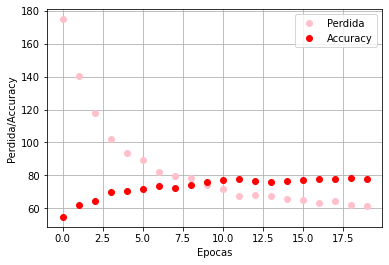

In [16]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww,ss)

In [17]:
#entrenamos el modelo estrandar recien creado para 20 epocas, lr de 1e-4
ww, ss = entrename(X = loader_train, Y = loader_test, modelo = estandar, epocas = 20, learningRate = 1e-4)

Epoca: 0   Perdida:225.7893705368042   Accuracy:13.125
Epoca: 1   Perdida:218.0743932723999   Accuracy:18.203125
Epoca: 2   Perdida:211.80550575256348   Accuracy:22.5
Epoca: 3   Perdida:205.49765586853027   Accuracy:33.59375
Epoca: 4   Perdida:200.8924698829651   Accuracy:42.578125
Epoca: 5   Perdida:195.0421380996704   Accuracy:47.96875
Epoca: 6   Perdida:189.2168116569519   Accuracy:51.484375
Epoca: 7   Perdida:185.32409191131592   Accuracy:55.9375
Epoca: 8   Perdida:181.3706874847412   Accuracy:56.09375
Epoca: 9   Perdida:175.17765522003174   Accuracy:57.8125
Epoca: 10   Perdida:171.3763952255249   Accuracy:58.515625
Epoca: 11   Perdida:166.8786120414734   Accuracy:59.84375
Epoca: 12   Perdida:161.26156091690063   Accuracy:59.609375
Epoca: 13   Perdida:158.02844285964966   Accuracy:60.0
Epoca: 14   Perdida:153.32653284072876   Accuracy:63.828125
Epoca: 15   Perdida:152.825186252594   Accuracy:61.25
Epoca: 16   Perdida:148.46434354782104   Accuracy:62.34375
Epoca: 17   Perdida:144.49

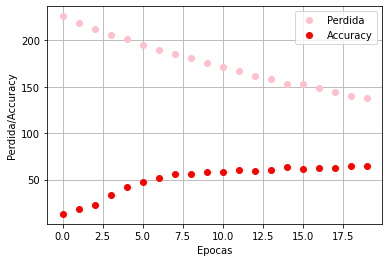

In [18]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww,ss)

In [19]:
#entrenamos el modelo estrandar recien creado para 20 epocas, lr de 1e-2
ww, ss = entrename(X = loader_train, Y = loader_test, modelo = estandar, epocas = 20, learningRate = 1e-2)

Epoca: 0   Perdida:72.35739827156067   Accuracy:75.390625
Epoca: 1   Perdida:66.64285659790039   Accuracy:75.9375
Epoca: 2   Perdida:58.11787128448486   Accuracy:78.90625
Epoca: 3   Perdida:56.2131667137146   Accuracy:78.4375
Epoca: 4   Perdida:51.9789981842041   Accuracy:82.734375
Epoca: 5   Perdida:51.92206263542175   Accuracy:80.46875
Epoca: 6   Perdida:48.53231489658356   Accuracy:82.03125
Epoca: 7   Perdida:46.95887863636017   Accuracy:81.796875
Epoca: 8   Perdida:48.84712100028992   Accuracy:82.578125
Epoca: 9   Perdida:45.327428579330444   Accuracy:84.53125
Epoca: 10   Perdida:46.92115247249603   Accuracy:84.375
Epoca: 11   Perdida:43.083054423332214   Accuracy:84.84375
Epoca: 12   Perdida:45.04889965057373   Accuracy:83.828125
Epoca: 13   Perdida:44.711923003196716   Accuracy:83.4375
Epoca: 14   Perdida:44.5868444442749   Accuracy:83.90625
Epoca: 15   Perdida:42.717132568359375   Accuracy:85.46875
Epoca: 16   Perdida:41.275015473365784   Accuracy:84.6875
Epoca: 17   Perdida:43.

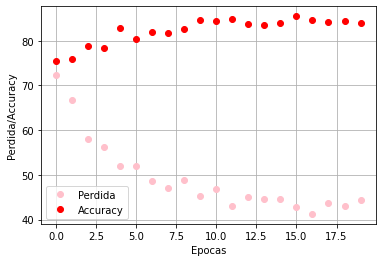

In [20]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww,ss)

In [21]:
#entrenamos el modelo estrandar recien creado para 20 epocas, lr de 1e-1
ww, ss = entrename(X = loader_train, Y = loader_test, modelo = estandar, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:56.163498759269714   Accuracy:79.765625
Epoca: 1   Perdida:48.23478817939758   Accuracy:81.171875
Epoca: 2   Perdida:44.52715218067169   Accuracy:83.203125
Epoca: 3   Perdida:44.85885262489319   Accuracy:83.28125
Epoca: 4   Perdida:36.981121301651   Accuracy:87.578125
Epoca: 5   Perdida:40.43768048286438   Accuracy:84.84375
Epoca: 6   Perdida:41.750293374061584   Accuracy:83.515625
Epoca: 7   Perdida:32.06938862800598   Accuracy:87.96875
Epoca: 8   Perdida:37.930009961128235   Accuracy:85.78125
Epoca: 9   Perdida:33.59504699707031   Accuracy:88.28125
Epoca: 10   Perdida:37.37058341503143   Accuracy:87.421875
Epoca: 11   Perdida:34.76406812667847   Accuracy:88.125
Epoca: 12   Perdida:35.784942507743835   Accuracy:87.1875
Epoca: 13   Perdida:32.70724833011627   Accuracy:87.03125
Epoca: 14   Perdida:31.343549489974976   Accuracy:88.359375
Epoca: 15   Perdida:34.02981698513031   Accuracy:88.4375
Epoca: 16   Perdida:32.384809255599976   Accuracy:87.265625
Epoca: 17   Perd

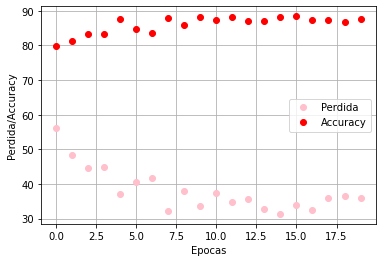

In [22]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww,ss)

In [23]:
#entrenamos el modelo estrandar recien creado para 20 epocas, lr de 1
ww, ss = entrename(X = loader_train, Y = loader_test, modelo = estandar, epocas = 20, learningRate = 1)

Epoca: 0   Perdida:166.96884870529175   Accuracy:46.40625
Epoca: 1   Perdida:147.8719997406006   Accuracy:41.953125
Epoca: 2   Perdida:197.3674750328064   Accuracy:32.96875
Epoca: 3   Perdida:199.34130191802979   Accuracy:15.859375
Epoca: 4   Perdida:178.32517623901367   Accuracy:39.0625
Epoca: 5   Perdida:183.76920700073242   Accuracy:39.375
Epoca: 6   Perdida:200.29544591903687   Accuracy:27.890625
Epoca: 7   Perdida:222.5752592086792   Accuracy:27.1875
Epoca: 8   Perdida:161.84511423110962   Accuracy:44.84375
Epoca: 9   Perdida:175.8854341506958   Accuracy:30.234375
Epoca: 10   Perdida:163.9788794517517   Accuracy:45.15625
Epoca: 11   Perdida:183.01214933395386   Accuracy:32.734375
Epoca: 12   Perdida:208.1591773033142   Accuracy:27.03125
Epoca: 13   Perdida:176.28790378570557   Accuracy:43.125
Epoca: 14   Perdida:180.01926183700562   Accuracy:37.34375
Epoca: 15   Perdida:167.57139444351196   Accuracy:48.75
Epoca: 16   Perdida:167.73386240005493   Accuracy:42.8125
Epoca: 17   Perdid

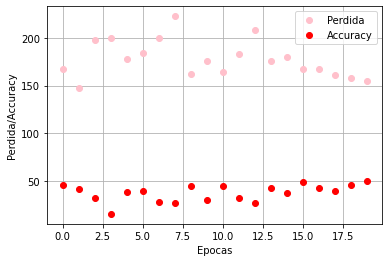

In [24]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww,ss)

Para el modelo estandar si bajamos el lr a 0.0001 el accuracy inicia muy bajo y parece que requiere de mas de 20 epocas para alcanzar un accuracy mayor a 75. Por otro lado si aumentamos el lr a 0.01 obtenemos un accuracy mayor a 80 al entrenar por 20 epocas. El limite lo encontramos al setear el lr de 1 donde el accuracy es menor a 50. Para este caso el parametro optimo es de lr = 0.1
Los siguientes experimentos tendran un lr de 0.1

In [25]:
#instanciamos una nueva arquitectura que contine 256 de salida
estandar1 = MLP(out=256).to(device, non_blocking=True)

In [26]:
#entrenamos el modelo estrandar con 256 de salida recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:55.35677909851074   Accuracy:79.21875
Epoca: 1   Perdida:47.2273713350296   Accuracy:82.03125
Epoca: 2   Perdida:44.01463449001312   Accuracy:83.4375
Epoca: 3   Perdida:43.50472390651703   Accuracy:83.75
Epoca: 4   Perdida:36.17335915565491   Accuracy:87.578125
Epoca: 5   Perdida:39.37412202358246   Accuracy:84.921875
Epoca: 6   Perdida:41.29025101661682   Accuracy:83.28125
Epoca: 7   Perdida:31.68968915939331   Accuracy:88.125
Epoca: 8   Perdida:36.81529223918915   Accuracy:87.109375
Epoca: 9   Perdida:33.299121260643005   Accuracy:87.8125
Epoca: 10   Perdida:38.44152629375458   Accuracy:86.015625
Epoca: 11   Perdida:34.75238084793091   Accuracy:87.421875
Epoca: 12   Perdida:35.26020646095276   Accuracy:87.421875
Epoca: 13   Perdida:33.46881031990051   Accuracy:87.109375
Epoca: 14   Perdida:31.392486691474915   Accuracy:88.4375
Epoca: 15   Perdida:33.07455360889435   Accuracy:88.28125
Epoca: 16   Perdida:30.091163516044617   Accuracy:88.828125
Epoca: 17   Perdida:33

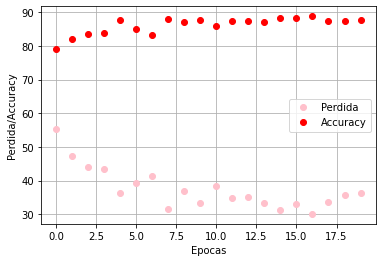

In [27]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

In [28]:
#instanciamos una nueva arquitectura que contine 1024 de salida
estandar1 = MLP(out=1024).to(device, non_blocking=True)
#entrenamos el modelo estrandar con 1024 de salida recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:54.84127342700958   Accuracy:79.296875
Epoca: 1   Perdida:45.842973589897156   Accuracy:81.5625
Epoca: 2   Perdida:42.13105618953705   Accuracy:83.90625
Epoca: 3   Perdida:42.600297927856445   Accuracy:84.375
Epoca: 4   Perdida:34.70237612724304   Accuracy:87.578125
Epoca: 5   Perdida:40.25590777397156   Accuracy:85.234375
Epoca: 6   Perdida:42.51107215881348   Accuracy:83.359375
Epoca: 7   Perdida:30.476781129837036   Accuracy:88.90625
Epoca: 8   Perdida:36.53892278671265   Accuracy:86.953125
Epoca: 9   Perdida:32.02424198389053   Accuracy:88.046875
Epoca: 10   Perdida:35.36674618721008   Accuracy:87.1875
Epoca: 11   Perdida:33.553653955459595   Accuracy:87.34375
Epoca: 12   Perdida:35.81546247005463   Accuracy:86.796875
Epoca: 13   Perdida:31.69713318347931   Accuracy:87.578125
Epoca: 14   Perdida:30.185070037841797   Accuracy:88.125
Epoca: 15   Perdida:32.50661313533783   Accuracy:88.75
Epoca: 16   Perdida:29.735006392002106   Accuracy:88.671875
Epoca: 17   Perdid

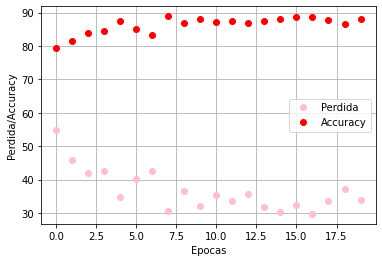

In [29]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

In [30]:
#instanciamos una nueva arquitectura que contine 8192 de salida
estandar1 = MLP(out=8192).to(device, non_blocking=True)
#entrenamos el modelo estrandar con 8192 de salida recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:49.690818190574646   Accuracy:82.1875
Epoca: 1   Perdida:41.88787639141083   Accuracy:83.515625
Epoca: 2   Perdida:39.85081195831299   Accuracy:84.6875
Epoca: 3   Perdida:38.67566525936127   Accuracy:85.703125
Epoca: 4   Perdida:32.34494149684906   Accuracy:88.28125
Epoca: 5   Perdida:40.13424277305603   Accuracy:84.921875
Epoca: 6   Perdida:39.041107296943665   Accuracy:84.921875
Epoca: 7   Perdida:28.75579446554184   Accuracy:89.140625
Epoca: 8   Perdida:35.26481807231903   Accuracy:87.03125
Epoca: 9   Perdida:30.933814644813538   Accuracy:89.0625
Epoca: 10   Perdida:35.306135416030884   Accuracy:87.34375
Epoca: 11   Perdida:33.70292603969574   Accuracy:88.046875
Epoca: 12   Perdida:35.42083382606506   Accuracy:87.265625
Epoca: 13   Perdida:31.75911009311676   Accuracy:88.203125
Epoca: 14   Perdida:28.900254368782043   Accuracy:89.765625
Epoca: 15   Perdida:31.168471574783325   Accuracy:89.375
Epoca: 16   Perdida:28.8713139295578   Accuracy:89.453125
Epoca: 17   Pe

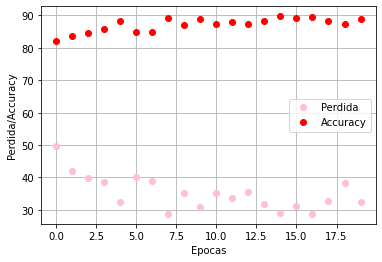

In [31]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

In [32]:
#instanciamos una nueva arquitectura que contine 32776 de salida
estandar1 = MLP(out=32776).to(device, non_blocking=True)
#entrenamos el modelo estrandar con 32776 de salida recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:44.01663661003113   Accuracy:83.75
Epoca: 1   Perdida:38.63214313983917   Accuracy:85.078125
Epoca: 2   Perdida:36.56540274620056   Accuracy:86.171875
Epoca: 3   Perdida:36.81920528411865   Accuracy:86.25
Epoca: 4   Perdida:30.17944633960724   Accuracy:89.140625
Epoca: 5   Perdida:42.697221636772156   Accuracy:85.15625
Epoca: 6   Perdida:36.598854064941406   Accuracy:85.859375
Epoca: 7   Perdida:27.963055968284607   Accuracy:89.21875
Epoca: 8   Perdida:33.67011070251465   Accuracy:87.890625
Epoca: 9   Perdida:30.226557552814484   Accuracy:89.53125
Epoca: 10   Perdida:32.616077065467834   Accuracy:88.90625
Epoca: 11   Perdida:36.44603669643402   Accuracy:87.1875
Epoca: 12   Perdida:35.87039649486542   Accuracy:87.578125
Epoca: 13   Perdida:31.747387647628784   Accuracy:88.28125
Epoca: 14   Perdida:28.417797684669495   Accuracy:90.15625
Epoca: 15   Perdida:31.04834496974945   Accuracy:89.765625
Epoca: 16   Perdida:28.735757172107697   Accuracy:89.453125
Epoca: 17   Per

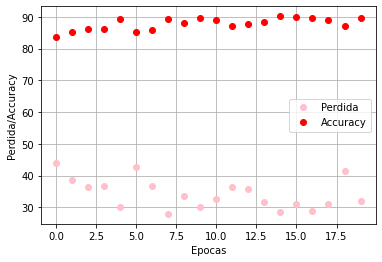

In [33]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

In [34]:
#instanciamos una nueva arquitectura que contine 102400 de salida
estandar1 = MLP(out=102400).to(device, non_blocking=True)
#entrenamos el modelo estrandar con 102400 de salida recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:48.48338305950165   Accuracy:84.921875
Epoca: 1   Perdida:36.849762201309204   Accuracy:86.5625
Epoca: 2   Perdida:36.311748027801514   Accuracy:86.328125
Epoca: 3   Perdida:37.779513001441956   Accuracy:86.328125
Epoca: 4   Perdida:29.636036157608032   Accuracy:89.296875
Epoca: 5   Perdida:49.979209899902344   Accuracy:84.296875
Epoca: 6   Perdida:33.876084089279175   Accuracy:88.515625
Epoca: 7   Perdida:27.865742444992065   Accuracy:89.453125
Epoca: 8   Perdida:32.74290055036545   Accuracy:88.90625
Epoca: 9   Perdida:30.50387352705002   Accuracy:90.46875
Epoca: 10   Perdida:32.31868922710419   Accuracy:89.375
Epoca: 11   Perdida:36.577041149139404   Accuracy:88.4375
Epoca: 12   Perdida:36.105186343193054   Accuracy:87.8125
Epoca: 13   Perdida:31.43734335899353   Accuracy:88.984375
Epoca: 14   Perdida:29.11708414554596   Accuracy:90.546875
Epoca: 15   Perdida:32.80156970024109   Accuracy:90.703125
Epoca: 16   Perdida:30.085421800613403   Accuracy:90.234375
Epoca: 1

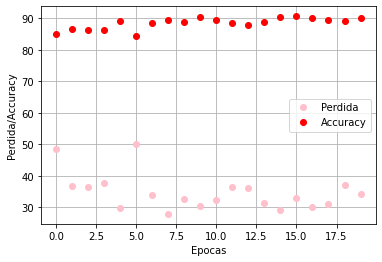

In [35]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

### Conclusiones del modelo estandar

Variar el learning rate y la cantidad de salidas en la capa oculta afectan el valor del accuracy de forma negativa o positiva segun sea el caso. Los experimentos mostraron que el lr optimo para este problema es de 0.1, mientras que aumentar las salidas beneficia el accuracy pero lo hace aparentemente de manera logaritmica (muy lento). Con este modelo no se logra obtener un accuracy de mas de 90. Es decir la convergencia es mas rapida. Podriamos esperar que el modelo alcance un accuracy mayor a 90 si ponemos mas epocas

### Arquitectura nueva

In [36]:
#doblamos el numero de capas con respecto al modelo original manteniendo las mismas funciones de activacion
#y doblando las salidas por capa, en general tendremos Fully conected (128 out) -> ReLU (128) -> Fully conected (256) ->
# ReLu (256) -> Fully conected (512) -> ReLu(512) -> Fully conected (10) -> Softmax (10)
class MLPModificada(nn.Module):
    #instanciador
    def __init__(self, out):
        #llamamos a la clase padre
        super(MLPModificada, self).__init__()
        #definimos el tamano de las capas de ante mano sabemos que es de 1*28*28
        self.I = 1* 28 * 28
        #definimos los nombres de las dos capas fully conected
        FC1, FC2 = out, 10
        #definimos las capas
        self.cls = nn.Sequential(
            #primer fully conected toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            nn.ReLU(),
            # segunda fully conected entrada de 128 y salida de 256
            nn.Linear(FC1, 2*FC1), nn.ReLU(),
            # tercera fully conected entrada de 256 y salida de 512
            nn.Linear(2*FC1, 4*FC1), nn.ReLU(),
            #ultima fully connected entrada de 512 y salida de 10 (clases)
            nn.Linear(4*FC1, FC2)
        )
        
    #inferencia
    def forward(self, x):
        #hacemos reshape de las imagenes (1,28,28) a (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x        

In [37]:
#instanciamos una nueva arquitectura que contine 128 de salida inicial
estandar2 = MLPModificada(out=128).to(device, non_blocking=True)
#entrenamos el modelo estrandar con 102400 de salida recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar2, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:58.0594527721405   Accuracy:77.734375
Epoca: 1   Perdida:50.254661440849304   Accuracy:80.0
Epoca: 2   Perdida:44.88637447357178   Accuracy:83.125
Epoca: 3   Perdida:47.56069362163544   Accuracy:82.03125
Epoca: 4   Perdida:36.52151942253113   Accuracy:87.421875
Epoca: 5   Perdida:42.24578857421875   Accuracy:84.140625
Epoca: 6   Perdida:42.6923793554306   Accuracy:82.578125
Epoca: 7   Perdida:32.512710094451904   Accuracy:87.96875
Epoca: 8   Perdida:40.2008593082428   Accuracy:84.375
Epoca: 9   Perdida:37.491987347602844   Accuracy:85.9375
Epoca: 10   Perdida:41.68714880943298   Accuracy:85.546875
Epoca: 11   Perdida:38.61461937427521   Accuracy:85.546875
Epoca: 12   Perdida:36.76884710788727   Accuracy:87.1875
Epoca: 13   Perdida:32.487093806266785   Accuracy:86.640625
Epoca: 14   Perdida:31.004375219345093   Accuracy:88.75
Epoca: 15   Perdida:32.75196194648743   Accuracy:88.75
Epoca: 16   Perdida:32.17122197151184   Accuracy:88.203125
Epoca: 17   Perdida:45.6784081

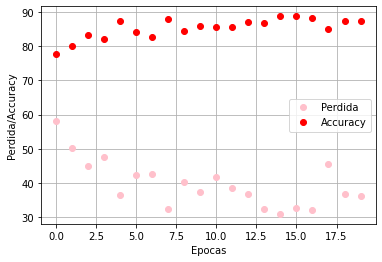

In [38]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

In [39]:
#instanciamos una nueva arquitectura que contine 128 de salida inicial
estandar2 = MLPModificada(out=128).to(device, non_blocking=True)
#entrenamos el modelo estrandar con 102400 de salida recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar2, epocas = 20, learningRate = 0.01)

Epoca: 0   Perdida:122.67364025115967   Accuracy:55.9375
Epoca: 1   Perdida:83.00089955329895   Accuracy:70.546875
Epoca: 2   Perdida:68.2376503944397   Accuracy:74.0625
Epoca: 3   Perdida:62.044057846069336   Accuracy:78.125
Epoca: 4   Perdida:55.40164649486542   Accuracy:80.78125
Epoca: 5   Perdida:55.09923279285431   Accuracy:78.671875
Epoca: 6   Perdida:50.885074734687805   Accuracy:81.171875
Epoca: 7   Perdida:48.78080725669861   Accuracy:81.71875
Epoca: 8   Perdida:51.49403512477875   Accuracy:80.9375
Epoca: 9   Perdida:45.443075299263   Accuracy:83.515625
Epoca: 10   Perdida:49.307451248168945   Accuracy:83.359375
Epoca: 11   Perdida:42.95902132987976   Accuracy:84.53125
Epoca: 12   Perdida:45.48655092716217   Accuracy:84.53125
Epoca: 13   Perdida:44.798464179039   Accuracy:84.0625
Epoca: 14   Perdida:43.87101173400879   Accuracy:83.515625
Epoca: 15   Perdida:42.877477407455444   Accuracy:85.546875
Epoca: 16   Perdida:41.06315851211548   Accuracy:85.46875
Epoca: 17   Perdida:43.

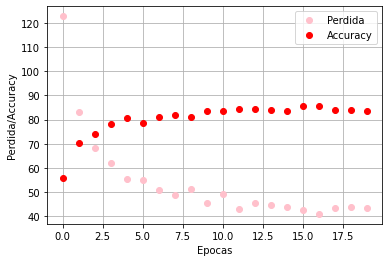

In [40]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

Parece que el lr sigue la misma tendencia con respecto al caso anterior por lo que nos mantendremos en lr=0.1

In [41]:
#instanciamos una nueva arquitectura que contine 512 de salida inical, las siguientes capas
#tendran salidas de 1024 y 2048 respectivamente
estandar2 = MLPModificada(out=512).to(device, non_blocking=True)
#entrenamos el modelo estrandar con 102400 de salida recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar2, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:57.792954444885254   Accuracy:77.96875
Epoca: 1   Perdida:47.33168363571167   Accuracy:81.328125
Epoca: 2   Perdida:44.50170040130615   Accuracy:83.046875
Epoca: 3   Perdida:45.13968884944916   Accuracy:82.421875
Epoca: 4   Perdida:35.08710861206055   Accuracy:88.203125
Epoca: 5   Perdida:41.727479100227356   Accuracy:84.296875
Epoca: 6   Perdida:40.178319811820984   Accuracy:84.21875
Epoca: 7   Perdida:30.180035829544067   Accuracy:88.984375
Epoca: 8   Perdida:38.07801365852356   Accuracy:85.859375
Epoca: 9   Perdida:38.46102952957153   Accuracy:85.9375
Epoca: 10   Perdida:40.008336305618286   Accuracy:85.546875
Epoca: 11   Perdida:40.683929324150085   Accuracy:84.765625
Epoca: 12   Perdida:36.88357055187225   Accuracy:87.03125
Epoca: 13   Perdida:31.801465153694153   Accuracy:87.734375
Epoca: 14   Perdida:29.109529852867126   Accuracy:89.296875
Epoca: 15   Perdida:31.901710629463196   Accuracy:88.984375
Epoca: 16   Perdida:31.363242268562317   Accuracy:88.59375
Epo

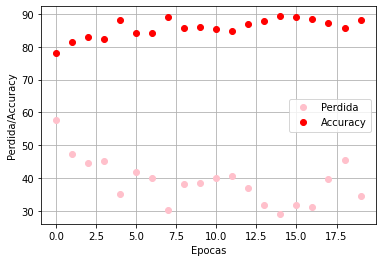

In [42]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

La mejora parece no ser sustancial, aumentemos por ultimo la salida inicial

CUIDADO! El siguiente entrenamiento ocupa aproximada mente 7 Gb de Vram segun windows

In [43]:
#instanciamos una nueva arquitectura que contine 8192 de salida inical, las siguientes capas
#tendran salidas de 1024 y 2048 respectivamente
estandar2 = MLPModificada(out=1024).to(device, non_blocking=True)
#entrenamos el modelo estrandar recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar2, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:55.951194763183594   Accuracy:79.453125
Epoca: 1   Perdida:47.60855555534363   Accuracy:81.015625
Epoca: 2   Perdida:43.76894652843475   Accuracy:83.203125
Epoca: 3   Perdida:43.664283752441406   Accuracy:82.8125
Epoca: 4   Perdida:33.83414089679718   Accuracy:88.28125
Epoca: 5   Perdida:42.20755696296692   Accuracy:84.53125
Epoca: 6   Perdida:39.92214322090149   Accuracy:84.21875
Epoca: 7   Perdida:30.333261489868164   Accuracy:88.203125
Epoca: 8   Perdida:36.55804991722107   Accuracy:86.25
Epoca: 9   Perdida:36.407724022865295   Accuracy:86.171875
Epoca: 10   Perdida:42.44613170623779   Accuracy:84.921875
Epoca: 11   Perdida:38.89804005622864   Accuracy:85.703125
Epoca: 12   Perdida:37.40278601646423   Accuracy:87.421875
Epoca: 13   Perdida:30.862333178520203   Accuracy:87.578125
Epoca: 14   Perdida:28.73349905014038   Accuracy:89.53125
Epoca: 15   Perdida:32.75878965854645   Accuracy:88.515625
Epoca: 16   Perdida:31.297077238559723   Accuracy:88.90625
Epoca: 17   

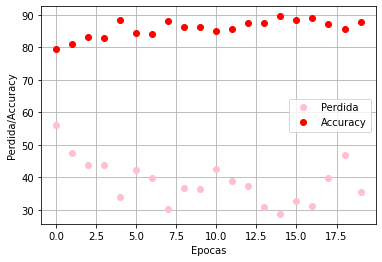

In [44]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

La mejora es nada!

### Conclusion de esta arquitectura

agregar dos capas ocultas mejora en 10 puntos el accuracy con respecto a la arquitectura original, sin embargo, el aumento de las salidas iniciales a mas de 128 no representan una mejora significativa e incluso pueden llenar la memoria de la GPU

In [45]:
#modelo estandar reshape -> fully conected -> Tanh -> fully conected -> softmax
class MLPAct(nn.Module):
    #instanciador
    def __init__(self, out):
        #llamamos a la clase padre
        super(MLPAct, self).__init__()
        #definimos el tamano de las capas de ante mano sabemos que es de 1*28*28
        self.I = 1* 28 * 28
        #definimos los nombres de las dos capas fully conected
        FC1, FC2 = out, 10
        #definimos las capas
        self.cls = nn.Sequential(
            #primer fully conected toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            #nn.Threshold(0.5, 0),
            nn.Tanh(),
            # segunda fully conected entrada de 128 y salida de 10 (clases)
            nn.Linear(FC1, FC2)
        )
        
    #inferencia
    def forward(self, x):
        #hacemos reshape de las imagenes (1,28,28) a (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x   

In [46]:
estandar2 = MLPAct(out=128).to(device, non_blocking=True)
#entrenamos el modelo estrandar recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar2, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:52.11698114871979   Accuracy:81.25
Epoca: 1   Perdida:49.798994064331055   Accuracy:80.9375
Epoca: 2   Perdida:45.17128825187683   Accuracy:82.8125
Epoca: 3   Perdida:44.55663323402405   Accuracy:82.890625
Epoca: 4   Perdida:37.9530131816864   Accuracy:87.578125
Epoca: 5   Perdida:40.63681721687317   Accuracy:84.921875
Epoca: 6   Perdida:41.95117175579071   Accuracy:83.515625
Epoca: 7   Perdida:33.87588858604431   Accuracy:86.953125
Epoca: 8   Perdida:38.526848554611206   Accuracy:85.625
Epoca: 9   Perdida:34.26643908023834   Accuracy:87.734375
Epoca: 10   Perdida:36.566916704177856   Accuracy:87.5
Epoca: 11   Perdida:33.224270939826965   Accuracy:88.75
Epoca: 12   Perdida:36.288893818855286   Accuracy:86.875
Epoca: 13   Perdida:34.16728377342224   Accuracy:86.71875
Epoca: 14   Perdida:32.15734124183655   Accuracy:87.734375
Epoca: 15   Perdida:33.85698080062866   Accuracy:87.578125
Epoca: 16   Perdida:31.580140590667725   Accuracy:87.734375
Epoca: 17   Perdida:34.727

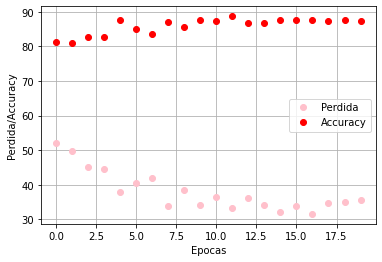

In [47]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

In [48]:
#modelo estandar reshape -> fully conected -> Tanh -> fully conected -> softmax
class MLPAct1(nn.Module):
    #instanciador
    def __init__(self, out):
        #llamamos a la clase padre
        super(MLPAct1, self).__init__()
        #definimos el tamano de las capas de ante mano sabemos que es de 1*28*28
        self.I = 1* 28 * 28
        #definimos los nombres de las dos capas fully conected
        FC1, FC2 = out, 10
        #definimos las capas
        self.cls = nn.Sequential(
            #primer fully conected toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            nn.ReLU(),
            # segunda fully conected entrada de 128 y salida de 256
            nn.Linear(FC1, FC1), nn.Sigmoid(),
            #ultima fully connected entrada de 128 y salida de 10 (clases)
            nn.Linear(FC1, FC2)
        )
        
    #inferencia
    def forward(self, x):
        #hacemos reshape de las imagenes (1,28,28) a (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x   

In [49]:
estandar2 = MLPAct1(out=128).to(device, non_blocking=True)
#entrenamos el modelo estrandar recien creado para 20 epocas, lr de 0.1
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar2, epocas = 20, learningRate = 0.1)

Epoca: 0   Perdida:67.69769191741943   Accuracy:74.53125
Epoca: 1   Perdida:60.14360785484314   Accuracy:78.359375
Epoca: 2   Perdida:52.72534251213074   Accuracy:81.015625
Epoca: 3   Perdida:51.677547097206116   Accuracy:81.328125
Epoca: 4   Perdida:44.45492506027222   Accuracy:84.453125
Epoca: 5   Perdida:46.31483554840088   Accuracy:82.265625
Epoca: 6   Perdida:44.635390639305115   Accuracy:82.578125
Epoca: 7   Perdida:39.85092282295227   Accuracy:84.765625
Epoca: 8   Perdida:45.95427870750427   Accuracy:82.96875
Epoca: 9   Perdida:37.47978925704956   Accuracy:86.640625
Epoca: 10   Perdida:41.34650766849518   Accuracy:85.46875
Epoca: 11   Perdida:36.928961873054504   Accuracy:87.5
Epoca: 12   Perdida:39.58508908748627   Accuracy:85.46875
Epoca: 13   Perdida:36.92974507808685   Accuracy:86.5625
Epoca: 14   Perdida:35.642913579940796   Accuracy:86.640625
Epoca: 15   Perdida:36.24616861343384   Accuracy:87.265625
Epoca: 16   Perdida:34.36351537704468   Accuracy:86.40625
Epoca: 17   Per

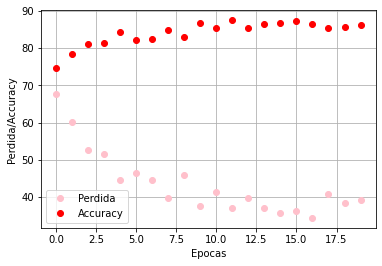

In [50]:
#graficamos el la perdida y el accuracy del modelo recien entrenado
grafica(ww1,ss1)

### Conclusion

basicamente un cambio de arquitectura no mejora el accuracy por lo que podriamos pensar que la arquitectura estandar es la mas optima para este problema